In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Sensitivity Analysis

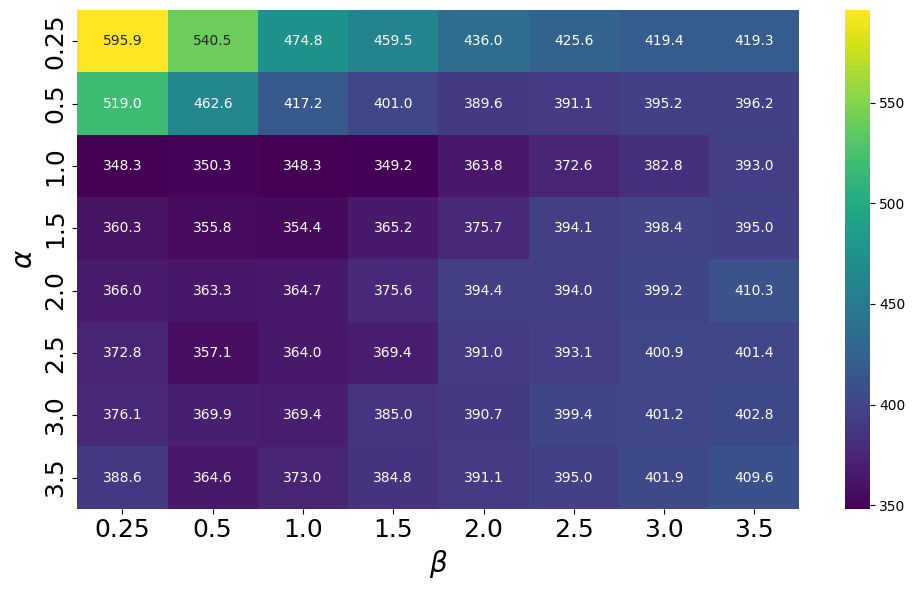

In [2]:
# Compute the mean best_fitness for each (alpha, beta) pair
Q_RHO_SENSITIVITY_DIR = os.path.join('output', 'sensitivity_analysis', 'sensitivity_alpha_beta.csv')
df_ab = pd.read_csv(Q_RHO_SENSITIVITY_DIR)
pivot_q_rho = df_ab.groupby(['alpha', 'beta'])['best_fitness'].mean().reset_index()
heatmap_ab = pivot_q_rho.pivot(index='alpha', columns='beta', values='best_fitness')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_ab,
    annot=True,
    fmt=".1f",
    cmap='viridis',
    cbar_kws={'label': None}  # No colorbar label
)
plt.xlabel(r'$\beta$', fontsize=20)
plt.ylabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


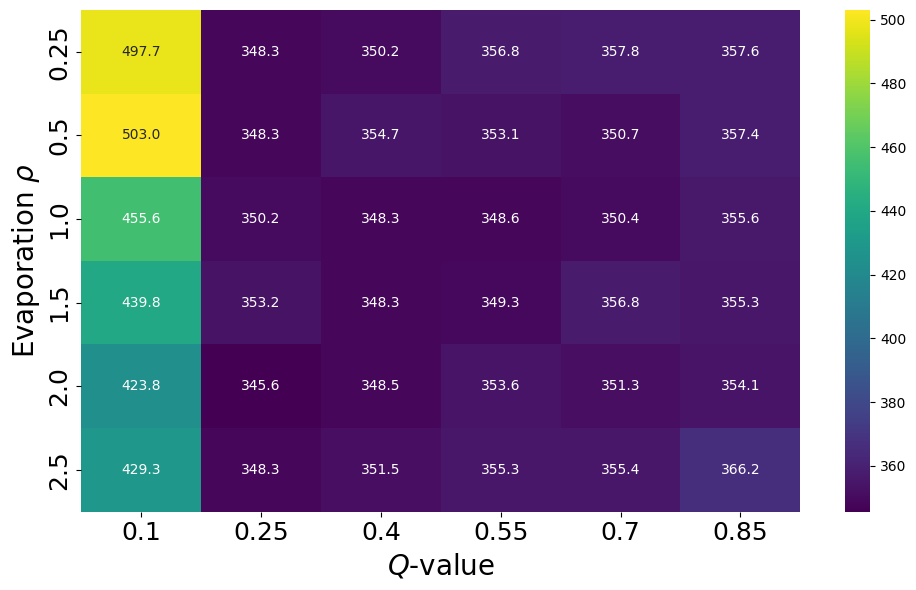

In [3]:
# Compute the mean best_fitness for each (alpha, beta) pair
Q_RHO_SENSITIVITY_DIR = os.path.join('output', 'sensitivity_analysis', 'sensitivity_Q_evaporation_rate.csv')
df_q_rho = pd.read_csv(Q_RHO_SENSITIVITY_DIR)
pivot_q_rho = df_q_rho.groupby(['Q', 'evaporation_rate'])['best_fitness'].mean().reset_index()
heatmap_ab = pivot_q_rho.pivot(index='Q', columns='evaporation_rate', values='best_fitness')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_ab,
    annot=True,
    fmt=".1f",
    cmap='viridis',
    cbar_kws={'label': None}  # No colorbar label
)
plt.xlabel(r'$Q$-value', fontsize=20)
plt.ylabel(r'Evaporation $\rho$', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()


# Speedup

In [4]:
SPEEDUP_DIR = os.path.join('output', 'speedup_analysis', 'scaling_vs_cores.large.csv')
df_speedup = pd.read_csv(SPEEDUP_DIR) # instance_scale,instance_name,core_count,num_ants,batch_size,runtime,speedup,efficiency

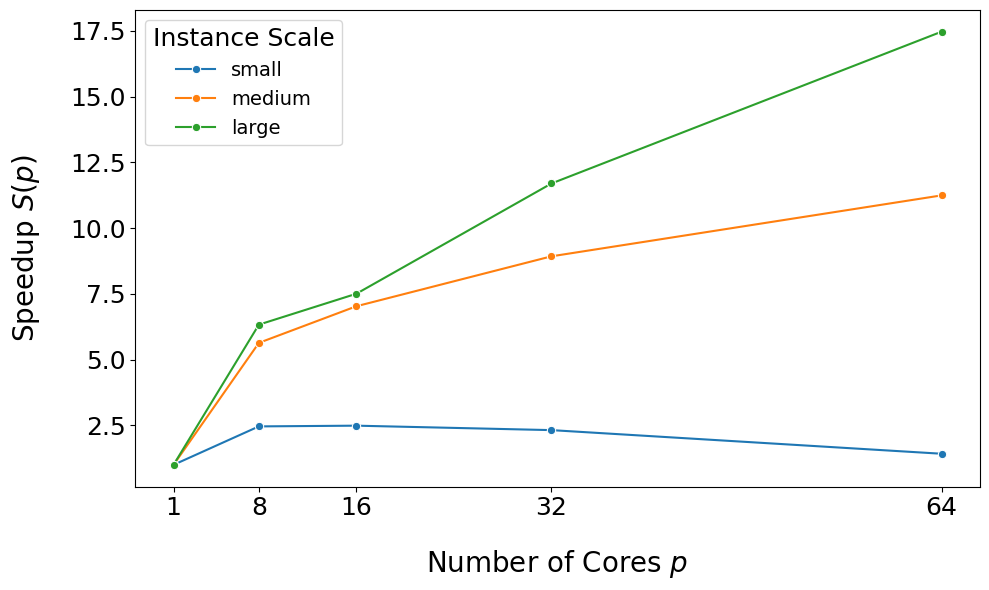

In [5]:
# Plot speedup vs core count
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_speedup,
    x='core_count',
    y='speedup',
    hue='instance_scale',
    marker='o'
)
plt.xlabel(r'Number of Cores $p$', fontsize=20, labelpad=20)
plt.ylabel(r'Speedup $S(p)$', fontsize=20, labelpad=20)
plt.xticks(sorted(df_speedup['core_count'].unique()), fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Instance Scale')
plt.tight_layout()
plt.legend(title='Instance Scale', title_fontsize=18, fontsize=14)
plt.show()

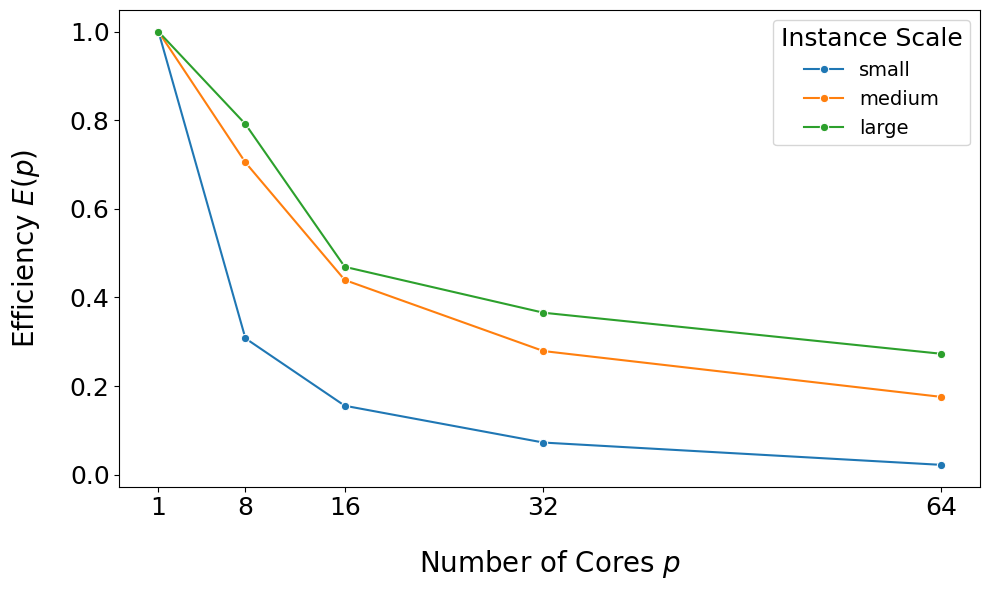

In [6]:
# Plot efficiency vs core count
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_speedup,
    x='core_count',
    y='efficiency',
    hue='instance_scale',
    marker='o'
)
plt.xlabel(r'Number of Cores $p$', fontsize=20, labelpad=20)
plt.ylabel(r'Efficiency $E(p)$', fontsize=20, labelpad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(title='Instance Scale')
plt.xticks(sorted(df_speedup['core_count'].unique()))
plt.tight_layout()
plt.legend(title='Instance Scale', title_fontsize=18, fontsize=14)
plt.show()

# Gap analysis

## Large size

In [72]:
LARGE_INSTANCES = os.path.join('output', 'wilcoxin', 'large.gap.csv')
df_large = pd.read_csv(LARGE_INSTANCES, delimiter='\t') # instances	best_1	avg_1	best_2	avg_2
df_large["gap_best"] = (df_large["best_2"] - df_large["best_1"]) / df_large["best_1"] * 100
df_large["gap_avg"] = (df_large["avg_2"] - df_large["avg_1"]) / df_large["avg_1"] * 100
df_large.head()

,instances,best_1,avg_1,best_2,avg_2,gap_best,gap_avg
0,C101_co_100,827.6,849.26,772.22,778.44,-6.691638,-8.339025
1,C102_co_100,1026.7,1046.96,875.09,885.48,-14.766728,-15.423703
2,C103_co_100,879.0,890.74,708.91,718.80,-19.350398,-19.303051
3,C104_co_100,700.4,710.06,635.26,658.59,-9.300400,-7.248683
4,C105_co_100,950.5,989.52,785.21,808.60,-17.389795,-18.283612


In [77]:
# Perform a Wilcoxon Signed-Rank Test to compare the best_1 vs best_2, alpha = 0.05, one-tailed (best_1 > best_2)
# Perform Wilcoxon test by instance, group by "C / R / RC".

def wilcoxon_by_instance(df, instance_type, size, to_path=None, alternative="greater"):
    def print_wilcoxon_results(stat, p_value, alpha=0.05, alternative="greater"):
        print(f"Wilcoxon statistic: {stat:f}, P-value: {p_value:f}")
        if p_value < alpha:
            if alternative == "greater":
                print("-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.")
            elif alternative == "less":
                print("-> Reject the null hypothesis: sample 1 is significantly less than sample 2.")
            else:
                print("-> Reject the null hypothesis: significant difference found.")
        else:
            print("Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).")
    if instance_type == "RC":
        df_instance = df[df['instances'].str.startswith("RC")]
    elif instance_type == "R":
        df_instance = df[df['instances'].str.startswith("R") & ~df['instances'].str.startswith("RC")]
    elif instance_type == "C":
        df_instance = df[df['instances'].str.startswith("C")]
    else:
        df_instance = pd.DataFrame()  # empty
    print(f"Number of {instance_type} instances: {len(df_instance)}")
    print("==" * 50)
    results = []
    if not df_instance.empty:
        # Wilcoxon test for best_1 vs best_2 (one-sided: best_1 > best_2 or best_1 < best_2)
        try:
            stat, p_value = stats.wilcoxon(df_instance['best_1'], df_instance['best_2'], alternative=alternative)
            print(f"Wilcoxon Signed-Rank Test for {instance_type} instances (best_1 {alternative} best_2):")
            print_wilcoxon_results(stat, p_value, alternative=alternative)
            results.append({
                "size": size,
                "instance_type": instance_type,
                "metric": "best",
                "alternative": alternative,
                "wilcoxon_statistics": stat,
                "p-value": p_value
            })
        except ValueError as e:
            print(f"Wilcoxon test could not be performed for best_1 vs best_2: {e}")
            results.append({
                "instance_type": instance_type,
                "wilcoxon_statistics": None,
                "p-value": None
            })
        print("--" * 25)
        # Wilcoxon test for avg_1 vs avg_2 (one-sided: avg_1 > avg_2 or avg_1 < avg_2)
        try:
            stat, p_value = stats.wilcoxon(df_instance['avg_1'], df_instance['avg_2'], alternative=alternative)
            print(f"Wilcoxon Signed-Rank Test for {instance_type} instances (avg_1 {alternative} avg_2):")
            print_wilcoxon_results(stat, p_value, alternative=alternative)
            results.append({
                "size": size,
                "instance_type": instance_type,
                "metric": "avg",
                "alternative": alternative,
                "wilcoxon_statistics": stat,
                "p-value": p_value
            })
        except ValueError as e:
            print(f"Wilcoxon test could not be performed for avg_1 vs avg_2: {e}")
            results.append({
                "instance_type": instance_type,
                "wilcoxon_statistics": None,
                "p-value": None
            })
        # Export results to CSV
        # results_df = pd.DataFrame(results)
        # results_df.to_csv(f"{instance_type}.csv" if to_path is None else to_path, index=False)
    else:
        print("No instances found.")
    print("--" * 50)

In [ ]:
# Perform a Wilcoxon Signed-Rank Test to check if gap_best and gap_avg are significantly different from zero
def wilcoxon_gap(df, instance_type, size, to_path=None):
    def print_gap_wilcoxon_results(stat, p_value, alpha=0.05):
        print(f"Wilcoxon statistic: {stat:f}, P-value: {p_value:f}")
        if p_value < alpha:
            print("-> Reject the null hypothesis: gap is significantly different from zero.")
        else:
            print("Fail to reject the null hypothesis: gap is not significantly different from zero.")

    # Filter by instance type
    if instance_type == "RC":
        df_instance = df[df['instances'].str.startswith("RC")]
    elif instance_type == "R":
        df_instance = df[df['instances'].str.startswith("R") & ~df['instances'].str.startswith("RC")]
    elif instance_type == "C":
        df_instance = df[df['instances'].str.startswith("C")]
    else:
        df_instance = pd.DataFrame()  # empty

    print(f"Number of {instance_type} instances: {len(df_instance)}")
    print("==" * 50)
    results = []
    if not df_instance.empty:
        # Wilcoxon test for gap_best vs 0
        try:
            stat, p_value = stats.wilcoxon(df_instance['gap_best'], zero_method='wilcox', alternative='two-sided')
            print(f"Wilcoxon Signed-Rank Test for {instance_type} instances (gap_best vs 0):")
            print_gap_wilcoxon_results(stat, p_value)
            results.append({
                "size": size,
                "instance_type": instance_type,
                "metric": "gap_best",
                "wilcoxon_statistics": stat,
                "p-value": p_value
            })
        except ValueError as e:
            print(f"Wilcoxon test could not be performed for gap_best: {e}")
            results.append({
                "instance_type": instance_type,
                "metric": "gap_best",
                "wilcoxon_statistics": None,
                "p-value": None
            })
        print("--" * 25)
        # Wilcoxon test for gap_avg vs 0
        try:
            stat, p_value = stats.wilcoxon(df_instance['gap_avg'], zero_method='wilcox', alternative='two-sided')
            print(f"Wilcoxon Signed-Rank Test for {instance_type} instances (gap_avg vs 0):")
            print_gap_wilcoxon_results(stat, p_value)
            results.append({
                "size": size,
                "instance_type": instance_type,
                "metric": "gap_avg",
                "wilcoxon_statistics": stat,
                "p-value": p_value
            })
        except ValueError as e:
            print(f"Wilcoxon test could not be performed for gap_avg: {e}")
            results.append({
                "instance_type": instance_type,
                "metric": "gap_avg",
                "wilcoxon_statistics": None,
                "p-value": None
            })
        # Export results to CSV
        # results_df = pd.DataFrame(results)
        # results_df.to_csv(f"{instance_type}_gap_significance.csv" if to_path is None else to_path, index=False)
    else:
        print("No instances found.")
    print("--" * 50)

In [78]:

# wilcoxon_gap(df_large, "C", size="large", to_path="output/wilcoxin/large.C.csv")
wilcoxon_by_instance(df_large, "C", size="large", to_path="output/wilcoxin/large.C.csv", alternative="less")
wilcoxon_by_instance(df_large, "R", size="large", to_path="output/wilcoxin/large.R.csv", alternative="less")
wilcoxon_by_instance(df_large, "RC", size="large", to_path="output/wilcoxin/large.RC.csv", alternative="less")

Number of C instances: 17
Wilcoxon Signed-Rank Test for C instances (best_1 less best_2):
Wilcoxon statistic: 117.000000, P-value: 0.974731
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
--------------------------------------------------
Wilcoxon Signed-Rank Test for C instances (avg_1 less avg_2):
Wilcoxon statistic: 120.000000, P-value: 0.982605
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
----------------------------------------------------------------------------------------------------
Number of R instances: 23
Wilcoxon Signed-Rank Test for R instances (best_1 less best_2):
Wilcoxon statistic: 141.000000, P-value: 0.541576
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
--------------------------------------------------
Wilcoxon Signed-Rank Test for R instances (avg_1 less avg_2):
Wilcoxon statistic: 116.000000, P-value: 0.260115
Fail to reject the null hypothesis:

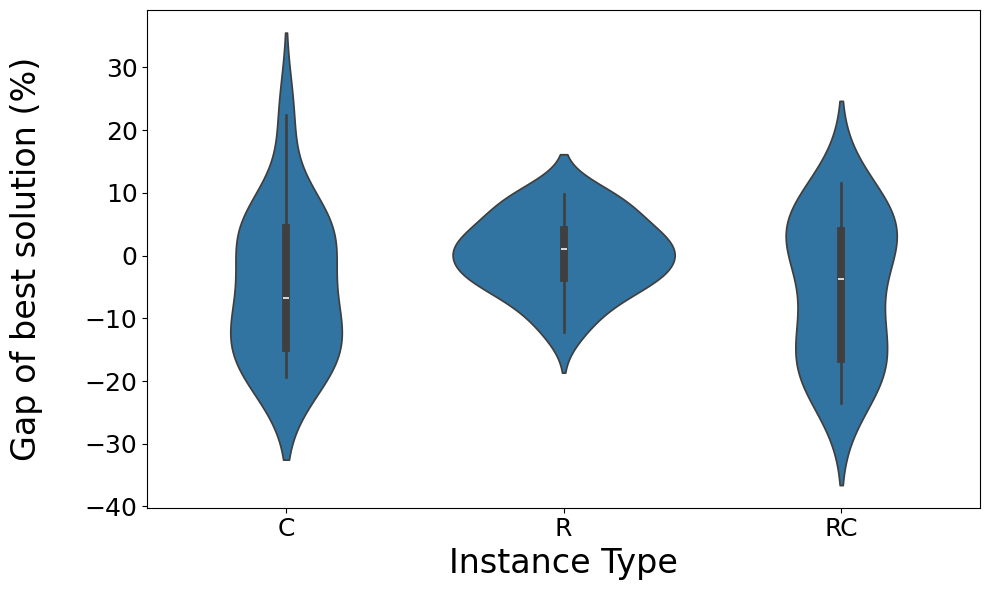

In [63]:
# Plot the gaps distribution by instance type using boxplot (all in one chart)
def plot_gaps(df):
    # Assign instance type
    def get_instance_type(name):
        if name.startswith("RC"):
            return "RC"
        elif name.startswith("R"):
            return "R"
        elif name.startswith("C"):
            return "C"
        else:
            return "Other"
    df = df.copy()
    df["instance_type"] = df["instances"].apply(get_instance_type)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="instance_type", y="gap_best", data=df, order=["C", "R", "RC"])
    plt.xlabel("Instance Type", fontsize=24)
    plt.ylabel("Gap of best solution (%)", fontsize=24, labelpad=30)  # Increase labelpad for more margin
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.show()

plot_gaps(df_large)

## Mediums-zize

In [64]:
MEDIUM_INSTANCES = os.path.join('output', 'wilcoxin', 'gap.medium.csv')
df_medium = pd.read_csv(MEDIUM_INSTANCES, delimiter='\t') # instances	best_1	avg_1	best_2	avg_2
df_medium["gap_best"] = (df_medium["best_2"] - df_medium["best_1"]) / df_medium["best_1"] * 100
df_medium["gap_avg"] = (df_medium["avg_2"] - df_medium["avg_1"]) / df_medium["avg_1"] * 100

In [79]:
# Perform a paired t-test to compare the best_1 vs best_2, alpha = 0.05, one-tailed (best_1 > best_2)
wilcoxon_by_instance(df_medium, "R", size="medium", to_path="output/wilcoxin/medium.R.csv", alternative="less")
wilcoxon_by_instance(df_medium, "C", size="medium", to_path="output/wilcoxin/medium.C.csv", alternative="less")
wilcoxon_by_instance(df_medium, "RC", size="medium", to_path="output/wilcoxin/medium.RC.csv", alternative="less")

Number of R instances: 23
Wilcoxon Signed-Rank Test for R instances (best_1 less best_2):
Wilcoxon statistic: 135.000000, P-value: 0.470277
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
--------------------------------------------------
Wilcoxon Signed-Rank Test for R instances (avg_1 less avg_2):
Wilcoxon statistic: 110.000000, P-value: 0.205020
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
----------------------------------------------------------------------------------------------------
Number of C instances: 17
Wilcoxon Signed-Rank Test for C instances (best_1 less best_2):
Wilcoxon statistic: 119.000000, P-value: 0.980232
Fail to reject the null hypothesis: no significant difference (sample 1 vs sample 2).
--------------------------------------------------
Wilcoxon Signed-Rank Test for C instances (avg_1 less avg_2):
Wilcoxon statistic: 125.000000, P-value: 0.991287
Fail to reject the null hypothesis:

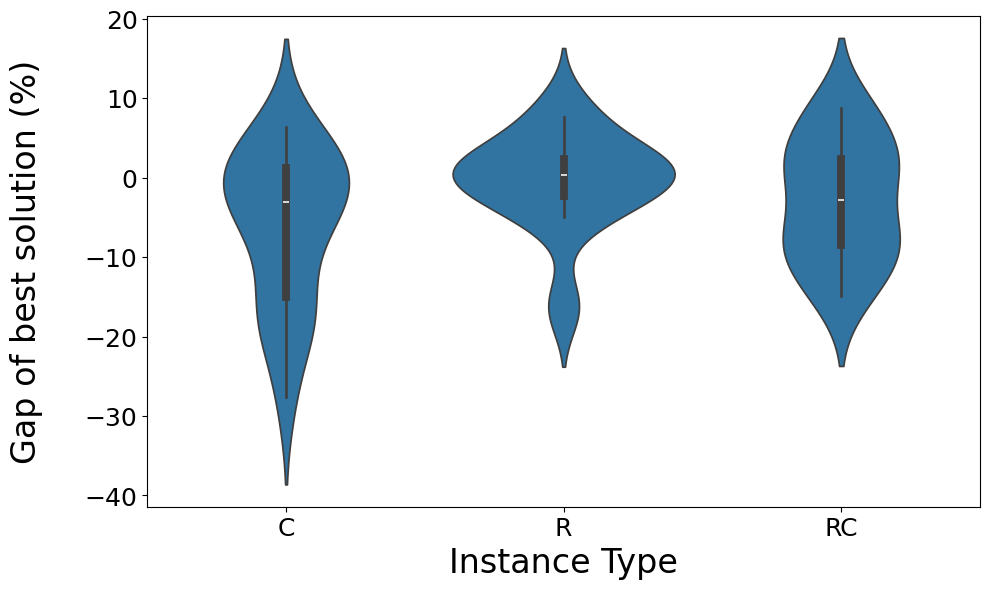

In [66]:
# Show the violin plot of gaps distribution by instance type
plot_gaps(df_medium)

## Small-zize

In [67]:
SMALL_INSTANCES = os.path.join('output', 'wilcoxin', 'gap.small.csv')
df_small = pd.read_csv(SMALL_INSTANCES, delimiter='\t') # instances	best_1	avg_1	best_2	avg_2
df_small["gap_best"] = (df_small["best_2"] - df_small["best_1"]) / df_small["best_1"] * 100
df_small["gap_avg"] = (df_small["avg_2"] - df_small["avg_1"]) / df_small["avg_1"] * 100

In [ ]:
# Perform a paired t-test to compare the best_1 vs best_2, alpha = 0.05, one-tailed (best_1 > best_2)
wilcoxon_by_instance(df_medium, "C", "small", to_path="output/wilcoxin/small.C.csv", alternative="less")
wilcoxon_by_instance(df_medium, "R", "small", to_path="output/wilcoxin/small.R.csv", alternative="less")
wilcoxon_by_instance(df_medium, "RC", "small", to_path="output/wilcoxin/small.RC.csv", alternative="less")

Number of C instances: 17
Wilcoxon Signed-Rank Test for C instances (gap_best vs 0):
Wilcoxon statistic: 36.000000, P-value: 0.056885
Fail to reject the null hypothesis: gap is not significantly different from zero.
--------------------------------------------------
Wilcoxon Signed-Rank Test for C instances (gap_avg vs 0):
Wilcoxon statistic: 30.000000, P-value: 0.026672
-> Reject the null hypothesis: gap is significantly different from zero.
----------------------------------------------------------------------------------------------------
Number of R instances: 23
Wilcoxon Signed-Rank Test for R instances (gap_best vs 0):
Wilcoxon statistic: 131.000000, P-value: 0.846232
Fail to reject the null hypothesis: gap is not significantly different from zero.
--------------------------------------------------
Wilcoxon Signed-Rank Test for R instances (gap_avg vs 0):
Wilcoxon statistic: 105.000000, P-value: 0.329405
Fail to reject the null hypothesis: gap is not significantly different from 

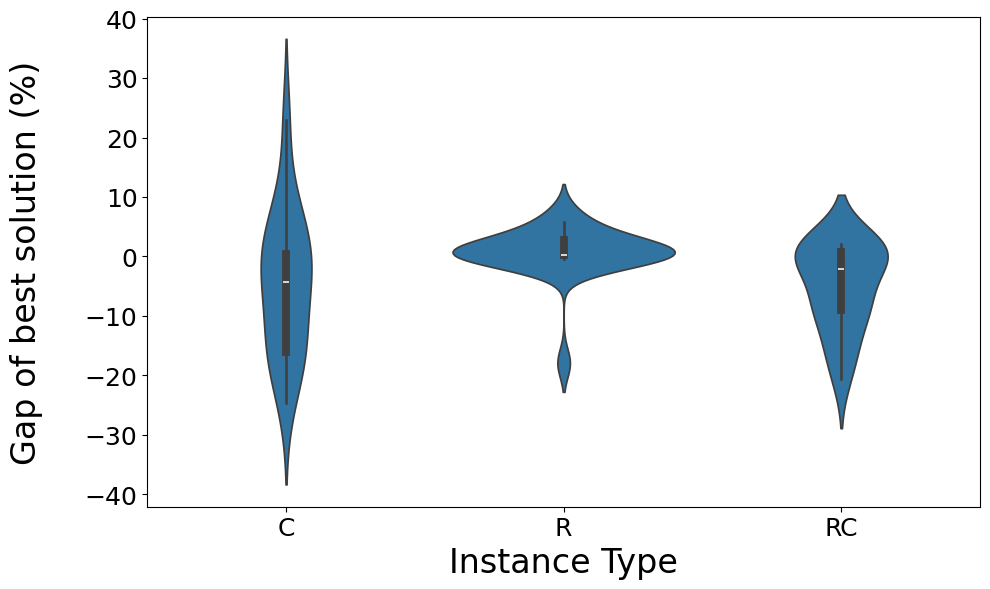

In [69]:
# Show the violin plot of gaps distribution by instance type
plot_gaps(df_small)

## Overall

In [70]:
def wilcoxon_one_tailed(df, title=""):
    print("Wilcoxon Signed-Rank Test for", title)
    print("(best_1 vs best_2, alternative='greater': sample 1 > sample 2):")
    try:
        stat, p_value = stats.wilcoxon(df['best_1'], df['best_2'], alternative='greater')
        print(f"Wilcoxon statistic: {stat:f}, P-value: {p_value:f}")
        if p_value < 0.05:
            print("-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.")
        else:
            print("Fail to reject the null hypothesis: no significant difference (sample 1 > sample 2).")
    except ValueError as e:
        print(f"Wilcoxon test could not be performed for best_1 vs best_2: {e}")
    print("--" * 25)
    print("(avg_1 vs avg_2, alternative='greater': sample 1 > sample 2):")
    try:
        stat, p_value = stats.wilcoxon(df['avg_1'], df['avg_2'], alternative='greater')
        print(f"Wilcoxon statistic: {stat:f}, P-value: {p_value:f}")
        if p_value < 0.05:
            print("-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.")
        else:
            print("Fail to reject the null hypothesis: no significant difference (sample 1 > sample 2).")
    except ValueError as e:
        print(f"Wilcoxon test could not be performed for avg_1 vs avg_2: {e}")
    print("==" * 50)

# Example usage for each dataset:
wilcoxon_one_tailed(df_large, "Large Instances")
wilcoxon_one_tailed(df_medium, "Medium Instances")
wilcoxon_one_tailed(df_small, "Small Instances")

Wilcoxon Signed-Rank Test for Large Instances
(best_1 vs best_2, alternative='greater': sample 1 > sample 2):
Wilcoxon statistic: 1055.000000, P-value: 0.018025
-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.
--------------------------------------------------
(avg_1 vs avg_2, alternative='greater': sample 1 > sample 2):
Wilcoxon statistic: 1005.000000, P-value: 0.045656
-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.
Wilcoxon Signed-Rank Test for Medium Instances
(best_1 vs best_2, alternative='greater': sample 1 > sample 2):
Wilcoxon statistic: 1043.000000, P-value: 0.022832
-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.
--------------------------------------------------
(avg_1 vs avg_2, alternative='greater': sample 1 > sample 2):
Wilcoxon statistic: 1001.000000, P-value: 0.048872
-> Reject the null hypothesis: sample 1 is significantly greater than sample 2.
Wilcoxon Signed-Rank Test for